# Using Multi-armed Bandits to Determine Best Website Layout

We aim to maximize the number of visitors who sign up to our website. Here, we figure out which of the 24 website configurations is the best, in the least amount of tries as possible. 

4 Multi-Armed Bandit algorithms are implemented and compared.

#### Content

- [0. Recap of Dataset](#section0)
- [1. Uniform Exploration Algorithm](#section1)
- [2. Epsilon-greedy Algorithm](#section2)
- [3. Epsilon-greedy Algorithm with Learning Factor](#section3)
- [4. Upper Confidence Bound (UCB 1)](#section4)
- [5. Conclusion: Best Website Configuration is \#11!](#section5)
- [6. Comparing Algorithms using Cumulative Regret](#section6)
    - [6.1 Conclusion: Best Algorithm is UCB1](#section6.1)

In [1]:
# Import libraries and set parameters

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as r

from server_pull import pull

sns.set(font_scale=1.2)

# Set up parameters

a = 24 # arms
t = 500 # rounds

## 0. Recap of Dataset<a class="anchor" id="section0"></a>

The output that from the simulated dataset is a dictionary, e.g.:

```
{'Arm': '2', 'NetReward': 455, 'Pull': 30, 'Reward': 22}
```

- Arm: The arm that you pulled. In this case, you pulled arm 2.
- Net Reward: The total reward up to the current pull. In this case, your total reward so fair is 455. 
- Pull: How many times you have pulled. In this case, this is your 30th pull.
- Reward: Reward from current pull. In this case, your reward is 22/100.

If your application outputs data similarly, the following algorithms may be easily reapplied.

## 1. Uniform Exploration<a class="anchor" id="section1"></a>

In this algorithm:

1. Each arm is tried N times (exploration)
2. Arm $\hat{a}$ with highest reward is selected
3. Play $\hat{a}$ for all remaining rounds.


In [2]:
# Set up a DataFrame to collect rewards from arm pulls
reward_uni = pd.DataFrame(index=range(0,t),columns=range(0,a))
reward_uni.head()

# Set N
N = 10

# NEED TO CHANGE TO TRY ONE ARM PER TIME PERIOD, sequentially
# For each round N, add the reward to the DF
for j in range(a):
    for i in range(N*j,N*(j+1)):
        output = pull('user19', '7iAUuySv', j)
        reward_uni.loc[i, j] = output['Reward']
        
# Play the best arm for the rest of the duration
best_arm_play = reward_uni.mean().idxmax()

for i in range (N*a,t):
    output = pull('user19', '7iAUuySv', best_arm_play)
    reward_uni.loc[i, best_arm_play] = output['Reward']

In [3]:
# Best arm from uniform exploration defined as the arm that gives the highest rewards
best_arm_uni = reward_uni.mean().idxmax()

print('Uniform Exploration Results')
print("The best arm is: " + str(best_arm_uni))
print("The best mean reward is:" + str(round(reward_uni.mean()[best_arm_uni],2)))
print("The arm chosen by uniform exploration is: " + str(best_arm_play))
print("The mean reward of chosen arm is: " + str(round(reward_uni.mean()[best_arm_play],2)))
print("Exploration phase is: {} rounds".format(str(N*a)))

Uniform Exploration Results
The best arm is: 11
The best mean reward is:23.5
The arm chosen by uniform exploration is: 19
The mean reward of chosen arm is: 23.24
Exploration phase is: 240 rounds


## 2. Epsilon-greedy Algorithm<a class="anchor" id="section2"></a>

In this algorithm:

1. Toss a coin with success probability of epsilon ($\epsilon_t$)
2. If success, then explore randomly
3. If fail, choose arm with highest average reward so far


In [4]:
# Initialize containers

pull_counter = np.zeros(a)
reward_raw =pd.DataFrame(index=range(0,t+1),columns=range(0,a))
cum_mean = pd.DataFrame()
reward_raw.rename({24:'p'}, axis='columns', inplace = True)

epsilon=0.3
initial_a=0

In [5]:
for turn in range(t):
        
# Generate random p vs epsilon and determine arm to pull
    
    p = r.uniform(0,1)
    
    # to check only
    reward_raw.loc[turn, 'p'] = p

    if p>=epsilon or pull_counter.sum()==0: # exploit if p>=0.30 (70% exploit rate)

        ## For initial pull,
        
        if pull_counter.sum()==0:
            pull_arm=initial_a
            output = pull('user19', '7iAUuySv', pull_arm)

        ## For succeeding pulls to exploit,
        
        else:
            pull_arm= reward_raw.loc[:turn,:].mean().idxmax() #take culmulative mean up current round of all arms
            output = pull('user19', '7iAUuySv', pull_arm)
    
    else: # explore if p<30 (30% exploration rate)
        
        ## Initialize list of choices and exclude best arm 
        
        choices=list(range(0,24))
        remove_best_arm = reward_raw.loc[:turn,:].mean().idxmax()
        choices.remove(remove_best_arm)
        

        ## Randomly pull arm for truncated list
        
        pull_arm=r.choice(choices)
        output = pull('user19', '7iAUuySv', pull_arm)

# Update counters and containers before end of turn

    ## Refresh pull counter
    
    pull_counter[pull_arm]=pull_counter[pull_arm]+1

    ## Refresh reward_raw, reward_sum
    
    reward_raw.iloc[turn,pull_arm]=output['Reward']    
    cum_mean[turn]=reward_raw.loc[:turn,:].mean()


In [6]:
# Display best arm

reward_raw=reward_raw.replace(0,np.nan)
best_arm_egreedy = reward_raw.mean().idxmax()

print('Base Epsilon Greedy (EG) Results')
print("The best arm is: " + str(best_arm_egreedy))
print("The best mean reward is:" + str(round(reward_raw.mean()[best_arm_egreedy],2)))
print("The arm chosen by EG exploration is: " + str(reward_raw.mean().idxmax()))
print("The mean reward of chosen arm is: " + str(round(reward_raw.mean()[reward_raw.mean().idxmax()],2)))
print("Exploration phase is: {} rounds".format(str(t-reward_raw[best_arm_egreedy].count())))


# Store dfs, export csv as backup

egreedy_cum_mean=cum_mean.T.drop('p',axis=1)
egreedy_cum_mean=egreedy_cum_mean.replace(np.nan,0)
egreedy_reward_raw=reward_raw.copy()
egreedy_cum_mean.to_csv('egreedy_cum_mean.csv')
egreedy_reward_raw.to_csv('eg_reward_raw.csv')


Base Epsilon Greedy (EG) Results
The best arm is: 11
The best mean reward is:24.7
The arm chosen by EG exploration is: 11
The mean reward of chosen arm is: 24.7
Exploration phase is: 260 rounds


## 3. Epsilon-greedy Algorithm with Learning Factor<a class="anchor" id="section3"></a>

In this algorithm:

1. Toss a coin with success probability of epsilon ($\epsilon_t$)
    - $\epsilon_t$ reduces with time according to $\epsilon_t / (1 + pulls/decayfactor)$
2. If success, then explore randomly
3. If fail, choose arm with highest average reward so far

In [8]:
# Initialize containers

pull_counter = np.zeros(a)
reward_raw =pd.DataFrame(index=range(0,t+1),columns=range(0,a))
cum_mean = pd.DataFrame()
reward_raw.rename({24:'p'}, axis='columns', inplace = True)

epsilon=0.3
initial_a=0
decay=1000


for turn in range(t):
        
# Generate random p, epsilon for turn and determine arm to pull
   
    epsilon=epsilon/(1+np.sum(pull_counter)/decay)
    p = r.uniform(0,1)
    
    # to check only
    reward_raw.loc[turn, 'p'] = p

    if p>=epsilon or pull_counter.sum()==0: # exploit if p>=0.30 (70% exploit rate)

        ## For initial pull,
        
        if pull_counter.sum()==0:
            pull_arm=initial_a
            output = pull('user19', '7iAUuySv', pull_arm)

        ## For succeeding pulls to exploit,
        
        else:
            pull_arm= reward_raw.loc[:turn,:].mean().idxmax() #take culmulative mean up current round of all arms
            output = pull('user19', '7iAUuySv', pull_arm)
    
    else: # explore if p<30 (30% exploration rate)
        
        ## Initialize list of choices and exclude best arm 
        
        choices=list(range(0,24))
        remove_best_arm = reward_raw.loc[:turn,:].mean().idxmax()
        choices.remove(remove_best_arm)
        

        ## Randomly pull arm for truncated list
        
        pull_arm=r.choice(choices)
        output = pull('user19', '7iAUuySv', pull_arm)

# Update counters and containers before end of turn

    ## Refresh pull counter
    
    pull_counter[pull_arm]=pull_counter[pull_arm]+1

    ## Refresh reward_raw, reward_sum
    
    reward_raw.iloc[turn,pull_arm]=output['Reward']    
    cum_mean[turn]=reward_raw.loc[:turn,:].mean()

In [9]:
# Display best arm

reward_raw=reward_raw.replace(0,np.nan)
best_arm_egreedy_lf= reward_raw.mean().idxmax()

print('Base Epsilon Greedy - Learning Factor (EGL) Results')
print("The best arm is: " + str(best_arm_egreedy_lf))
print("The best mean reward is:" + str(round(reward_raw.mean()[best_arm_egreedy_lf],2)))
print("The arm chosen by EGL exploration is: " + str(reward_raw.mean().idxmax()))
print("The mean reward of chosen arm is: " + str(round(reward_raw.mean()[reward_raw.mean().idxmax()],2)))
print("Exploration phase is: {} rounds".format(str(t-reward_raw[best_arm_egreedy_lf].count())))


# Store dfs

egreedy_cum_mean_lf=cum_mean.T.drop('p',axis=1)
egreedy_cum_mean_lf=egreedy_cum_mean.replace(np.nan,0)
egreedy_reward_raw_lf=reward_raw.copy()


Base Epsilon Greedy - Learning Factor (EGL) Results
The best arm is: 11
The best mean reward is:24.51
The arm chosen by EGL exploration is: 11
The mean reward of chosen arm is: 24.51
Exploration phase is: 17 rounds


## 4. Upper Confidence Bound (UCB 1)<a class="anchor" id="section4"></a>

In this algorithm:

1. Play each arm once to initialize
2. At every round $t$,
    - Calculate the UCB index
    - Choose the arm with the highest UCB index

UCB index: $\mu_a(t) + \sqrt{\frac{2ln(t)}{n_a(t)}}$

where a = arm, t = round t.

- The first term ($\mu_a(t)$) encourages exploitation of arms that have a high expected mean reward.
- The second term would be higher for less-explored arms as t increases. This effectively increases the potential for the algorithm to explore these arms after some time.

In [11]:
# Set up a counter to collect number of tries for each arm
counter = np.zeros(a)

# Set up a DataFrame to collect rewards from arm pulls
reward = pd.DataFrame(index=range(0,t),columns=range(0,a))

# Set up a DataFrame to compute ucb index at each round 
ucb = pd.DataFrame(index=range(0, t),columns=range(0, a))
np.shape(ucb)

(500, 24)

In [12]:
# For loop to pull arms

# For each round...
for i in range(t):

    # initialize by playing all arms once
    if i == 0:
        for j in range(a):
            output = pull('user19', '7iAUuySv', j)
            reward.loc[i,j] = output['Reward'] #capture the reward
            ucb.loc[i,j] = reward.loc[:,j].mean() #update as the first line of the ucb term

    # if not 0, then start the UCB
    else:
        # pull the arm with the highest UCB index in the previous line
        chosen_arm = pd.to_numeric(ucb.loc[i-1]).idxmax(axis = 1)
        output = pull('user19', '7iAUuySv', chosen_arm)
        reward.loc[i,chosen_arm] = output['Reward'] #capture the reward
        counter[chosen_arm] = counter[chosen_arm] + 1 #add 1 to the arm's counter (numpy array, zero indexed)
        
        # For all arms, carry forward the UCB term
        ucb.loc[i] = ucb.loc[i-1]
        
        # Update UCB term for the arm that was pulled
        mean_a_t = reward.loc[:,chosen_arm].mean()
        correction = (2*np.log(i)/counter[chosen_arm])**(1/2) # ln(round) / pull adjustment
        ucb.loc[i,chosen_arm] = mean_a_t + correction
     

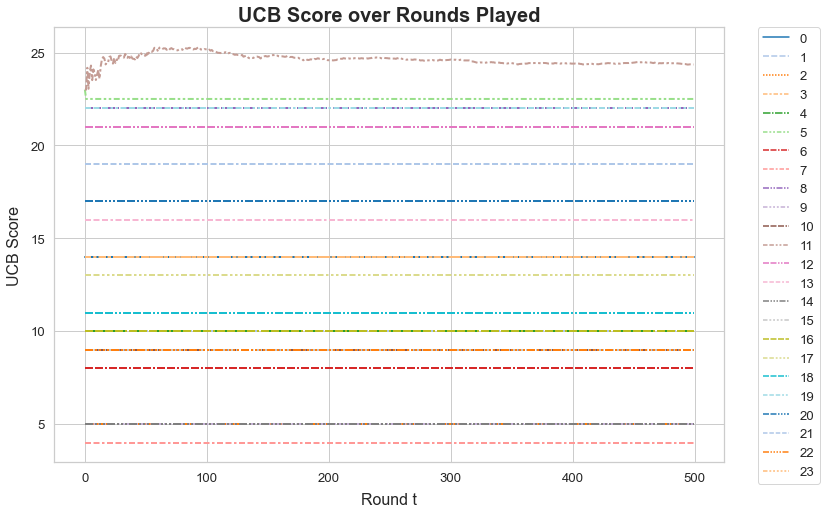

In [13]:
sns.set_style("whitegrid")

fig = plt.figure(figsize = [12,8])

plt.title('UCB Score over Rounds Played', fontsize=20, weight='bold')
plt.xlabel("Round t", size=16, labelpad=8)
plt.ylabel("UCB Score", size=16, labelpad=8)

sns.lineplot(data=ucb.apply(pd.to_numeric), palette = 'tab20', lw=2)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [14]:
# Best arm has the highest mean reward in hindsight
best_arm_ucb = reward.mean().idxmax()

# Arm chosen defined as the one that the algorithm plays as of the last round
ucb_final_played = reward.loc[t-1,:].notnull()
chosen_arm_ucb = reward.loc[t-1,:][ucb_final_played].index.to_list()[0]

# Find index of the last row where there is a nan, then +1 for 0-index and
# +1 for the next try when the best arm is found. All other tries from that point onwards is on the best arm.
nanrows = reward.loc[:,best_arm_ucb].isnull()
nanmax = reward[nanrows].index.max()

print("The best arm is: {}".format(best_arm_ucb))
print("The best mean reward is:" + str(round(reward.mean()[best_arm_ucb],2)))
print("The arm chosen by UCB is: " + str(chosen_arm_ucb))
print("The mean reward of chosen arm is: " + str(round(reward.mean()[chosen_arm_ucb],2)))
print("Exploration phase is:{}".format(nanmax+2))

The best arm is: 11
The best mean reward is:24.2
The arm chosen by UCB is: 11
The mean reward of chosen arm is: 24.2
Exploration phase is:3


## 5. Conclusion: Best Website Configuration is \#11!<a class="anchor" id="section5"></a>

Overall, it is clear that the <b>best arm is arm 11</b> as concluded by 3/4 algorithms. Uniform Exploration arrived at arm 19 instead which had a lower mean reward than the best arm.

<img src = "./images/mabresults.png" width="700"/>

## 6. Comparing Algorithms using Cumulative Regret<a class="anchor" id="section6"></a>

Cumulative expected regret was used to quantify the performance of different algorithms. This is quantified as the difference between <b>mean expected reward of the best arm ($\mu*$)</b>, known after the fact, versus the <b>mean expected reward of the arm tried in round t ($\mu(a_t)$)</b>. This representing a penalty for not choosing the best arm in each round and wasting tries on non-optimal arms. 

Regret: $R(T) = \mu* T - \sum_{t=1}^{T} \mu(a_t)$

where T = all time periods.

In [15]:
def regret(rewards_df, best_arm):
    
    # Define a global dataframe
    global regret_calc
    
    regret_calc = rewards_df.copy()
    
    # Add empty columns
    regret_calc['miu_a'] = np.nan
    regret_calc['cumulative_miu_a'] = np.nan
    regret_calc['regret'] = np.nan
    
    # average of best arm across all periods T
    regret_calc['miu_star'] = regret_calc[best_arm].mean()
    
    # compute regret
    for i in range(1,t):
    
        # get the index of arm that was pulled at time t
        miu_a_ix = np.where(regret_calc.iloc[i, :a].notnull())[0][0] 
        # get the mean of the arm that was pulled at time t over the entire t period
        miu_a = regret_calc[miu_a_ix].mean()

        # store miu_a in the dataframe
        regret_calc.loc[i,'miu_a'] = miu_a

        # compute cumulative miu_a
        regret_calc.loc[i,'cumulative_miu_a'] = regret_calc.loc[:,'miu_a'].sum()

        # compute and store regret at time t
        regret_calc.loc[i,'regret'] = regret_calc.loc[i,'miu_star'] * (i) - regret_calc.loc[i,'cumulative_miu_a']

In [16]:
# The regret_calc dataframe is overwritten with every function call
regret_plot = pd.DataFrame()

# Call regret on the Uniform reward df
regret(reward_uni, best_arm_uni)
regret_plot['Uniform'] = regret_calc['regret']

#Call regret on the UCB reward df
regret(reward, best_arm_ucb)
regret_plot['UCB'] = regret_calc['regret']

# Call regret on the base epsilon greedy
regret(egreedy_reward_raw, best_arm_egreedy)
regret_plot['eGreedy'] = regret_calc['regret']

# Call regret on the epsilon greedy with decay model
regret(egreedy_reward_raw_lf, best_arm_egreedy_lf)
regret_plot['eGreedy_Adaptive'] = regret_calc['regret']

regret_plot.tail()

,Uniform,UCB,eGreedy,eGreedy_Adaptive
495,2041.348148,1.696393,1730.245833,125.282609
496,2041.611111,1.696393,1730.245833,125.282609
497,2041.874074,1.696393,1730.245833,125.282609
498,2042.137037,1.696393,1730.245833,125.282609
499,2042.400000,1.696393,1730.245833,125.282609


### 6.1 Conclusion: Best Algorithm is UCB1<a class="anchor" id="section6.1"></a>

Summarising the above, the cumulative expected regret is as follows. UCB1 is clearly superior as it to quickly converge on the best configuration and begins the exploitation process earlier compared to other algorithms.

<img src = "./images/regret.png" width="700"/>

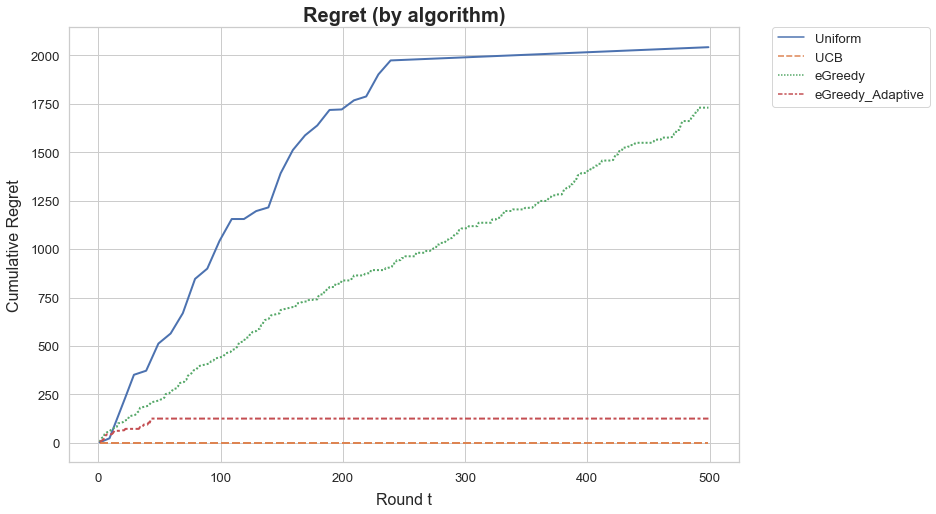

In [17]:
# We can stitch the regret columns for all and combine in a plot

sns.set_style("whitegrid")

fig = plt.figure(figsize = [12,8])

plt.title('Regret (by algorithm)', fontsize=20, weight='bold')
plt.xlabel("Round t", size=16, labelpad=8)
plt.ylabel("Cumulative Regret", size=16, labelpad=8)

sns.lineplot(data=regret_plot, lw=2)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()